# Project title: Diabet Prediction [notebook 'Diabet_Prediction_Models']

## Authors: Denys Herasymuk & Yaroslav Morozevych

## Contents of This Notebook

Click on the section and go to this cell immediately. (works only with Jupyter in browser)

* [Section 1. Explore Data](#section_1)
* [Section 2. Train and Validate Models](#section_2)
* [Section 3. Test Set Evaluation](#section_3)

When you use `Run All` button with this notebook, you should wait approx. 3-5 mins to get output of all cells.

**How to run this notebook**

* Create a new virtual env with python 3.8
* In terminal run  -- `pip install -r requirements.txt`

## General Configuration

In [247]:
import os
import sys
import math
import pickle
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as ss
import matplotlib.pyplot as plt

from pprint import pprint
from copy import deepcopy
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from utils import scale_normalize

In [248]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

## Python & Library Versions

In [249]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("statsmodels", ss.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.5
statsmodels 0.13.1
seaborn     0.11.2
sklearn     1.0.1


<a id='section_1'></a>

## Section 1. Explore Data

In [250]:
diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_processed.csv"))
diabetes_df = diabetes_df.iloc[: , 1:] # Drop first column of dataframe

In [251]:
diabetes_df.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
0,6,148,0,33.6,0.627,50,1.69,1
1,1,85,0,26.6,0.351,31,0.66,0
2,8,183,0,23.3,0.672,32,1.61,1
3,1,89,94,28.1,0.167,21,0.07,0
4,0,137,168,43.1,2.288,33,1.27,1


### Validate Data

In [252]:
diabetes_df.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,79.799479,31.992578,0.471876,33.240885,0.888828,0.348958
std,3.369578,31.972618,115.244002,7.884160,0.331329,11.760232,0.503496,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,0.000000,27.300000,0.243750,24.000000,0.470000,0.000000
50%,3.000000,117.000000,30.500000,32.000000,0.372500,29.000000,0.870000,0.000000
75%,6.000000,140.250000,127.250000,36.600000,0.626250,41.000000,1.230000,1.000000
max,17.000000,199.000000,846.000000,67.100000,2.420000,81.000000,2.250000,1.000000


In [253]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
DiabetesRisk                0
Outcome                     0
dtype: int64

In [254]:
# Selecting duplicate rows except first.
# Occurrence based on all columns
duplicates = diabetes_df[diabetes_df.duplicated()]

print("Duplicate rows :")
duplicates

Duplicate rows :


,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome


<a id='section_2'></a>

## Section 2. Train and Validate Models

### Prepare Data

In [255]:
# choose the most relevant features based on data analysis in 01_Process_Data_and_EDA.ipynb
features = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "DiabetesRisk", "Outcome"]
scaled_df = scale_normalize(df=diabetes_df, features=features)

In [256]:
# separate the dataframe onto features and target
features_df = scaled_df.drop("Outcome", axis="columns")
target_df = diabetes_df[['Outcome']]

In [257]:
SEED = 25
n_folds = 3

# split the data on test and train
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
samples_per_fold = len(y_test)
X_train.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,-0.000901,0.012476,0.012192,0.002368,0.007752,0.024265,0.013011
std,1.012489,1.011829,1.010449,1.004225,1.034108,0.996093,0.998618
min,-1.141852,-3.783654,-0.692891,-4.060474,-1.189553,-1.041549,-1.766465
25%,-0.844885,-0.685236,-0.692891,-0.595578,-0.687458,-0.786286,-0.832383
50%,-0.250952,-0.121888,-0.397672,0.000942,-0.322779,-0.360847,-0.037419
75%,0.639947,0.629244,0.435886,0.584771,0.467737,0.660206,0.678048
max,3.906578,2.444478,6.652839,4.455807,5.883565,3.297926,2.705205


### Train and Validation

In [258]:
def folds_iterator(n_folds, samples_per_fold, size):
    """
    Iterator for GridSearch based on Cross-Validation

    :param n_folds: number of folds for Cross-Validation
    :param samples_per_fold: number of samples per fold
    """
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)


In [259]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    """
    Use GridSearchCV for a special model to find the best hyperparameters based on validation set
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={
                                   "F1_Score": make_scorer(f1_score, average='macro'),
                                   "Accuracy_Score": make_scorer(accuracy_score),
                               },
                               refit="F1_Score",
                               n_jobs=-1,
                               cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y.values.ravel())
    best_index = grid_search.best_index_

    return grid_search.best_estimator_,\
           grid_search.cv_results_["mean_test_F1_Score"][best_index],\
           grid_search.cv_results_["mean_test_Accuracy_Score"][best_index],\
           grid_search.best_params_

#### Validate ML Models

In this part we find the best ML model among RandomForestClassifier, DecisionTreeClassifier and SVM.

In [260]:
def validate_ML_models(X, y, show_plots, debug_mode):
    """
    Find the best model from defined list.
    Tune each model on a validation set with GridSearchCV and
    return best_model with its hyperparameters, which has the highest F1 score
    """
    results_df = pd.DataFrame(columns=('Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    config_models = [
        {
            'model_name': 'RandomForestClassifier',
            'model': RandomForestClassifier(random_state=SEED),
            'params': {
                "bootstrap": [True, False],
                "max_depth": [3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "n_estimators": [200, 500, 1000],
                "max_features": [0.6, 'auto', 'sqrt']
            }
        },
        {
            'model_name': 'DecisionTreeClassifier',
            'model': DecisionTreeClassifier(random_state=SEED),
            'params': {
                "max_depth": [2, 3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "max_features": [0.6, 'auto', 'sqrt'],
                "criterion": ["gini", "entropy"]
            }
        },
        {
            'model_name': 'SVC',
            'model': SVC(random_state=SEED),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']
            }
        },
    ]

    best_f1_score = -np.Inf
    best_model = None
    best_model_name = 'No model'
    best_params = None
    idx = 0
    for model_config in config_models:
        cur_model, cur_f1_score, cur_accuracy, cur_params = validate_model(deepcopy(model_config['model']),
                                                                    X, y, model_config['params'],
                                                                    n_folds, samples_per_fold)
        if debug_mode:
            print('\nModel name: ', model_config['model_name'])
            print('Best model validation params: ')
            pprint(cur_params)

        results_df.loc[idx] = [model_config['model_name'],
                               cur_f1_score,
                               cur_accuracy,
                               cur_params]
        idx += 1

        if cur_f1_score > best_f1_score:
            best_f1_score = cur_f1_score
            best_model_name = model_config['model_name']
            best_model = cur_model
            best_params = cur_params

    return results_df, best_model, best_model_name, best_params

In [261]:
ML_results_df, best_model, best_model_name, best_params = validate_ML_models(X_train, y_train, show_plots=False, debug_mode=True)


Model name:  RandomForestClassifier
Best model validation params: 
{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

Model name:  DecisionTreeClassifier
Best model validation params: 
{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Model name:  SVC
Best model validation params: 
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [262]:
ML_results_df

,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,RandomForestClassifier,0.731121,0.770563,"{'bootstrap': True, 'max_depth': 4, 'max_featu..."
1,DecisionTreeClassifier,0.694253,0.735931,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
2,SVC,0.714156,0.757576,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}"


<a id='section_3'></a>

## Section 3. Test Set Evaluation

In [266]:
best_model.fit(X_train, y_train.values.ravel()) # refit model on the whole train set
model_pred = best_model.predict(X_test)

Best model:  RandomForestClassifier
Best model parameters:
{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

              precision    recall  f1-score   support

           0      0.823     0.903     0.861       103
           1      0.756     0.608     0.674        51

    accuracy                          0.805       154
   macro avg      0.790     0.755     0.768       154
weighted avg      0.801     0.805     0.799       154



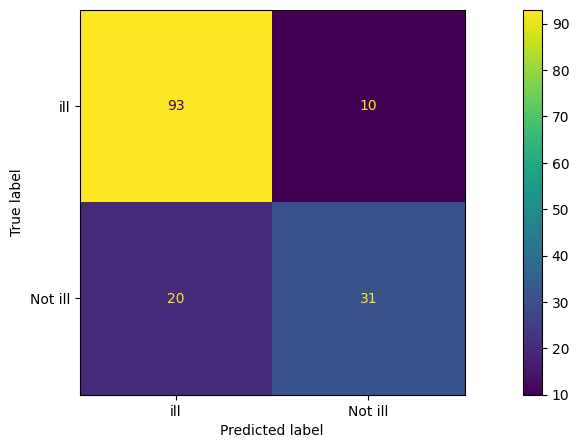

In [269]:
print('Best model: ', best_model_name)
print('Best model parameters:')
pprint(best_params)

# print the scores
print()
print(classification_report(y_test, model_pred, digits=3))

# plot the confusion matrix
cm = confusion_matrix(y_test, model_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
disp.plot()
plt.show()

### Retrain and save model

In [265]:
x = pd.concat((X_train, X_test))
y = pd.concat((y_train, y_test))
best_model.fit(x, y)

models_path = "models"
if not os.path.exists(models_path):
    os.mkdir(models_path)
pickle.dump(best_model, open(os.path.join(models_path, "diabet_prediction_model.pkl"), "wb"))